In [1]:
# imports
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import signal
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
import pickle
    
plt.style.use(astropy_mpl_style)

# Steps:
# look at .out file with all angles
# make dictionary with key=ffi_number and value equal to a tuple of all angles/values we want
# pickle dictionary to the angle folder
#
# look at the fits files with all of the numpy arrays for each image
# median filter, sigma-clip, and black out corners
# pickle the image to the ccd folder, then repeat for each image

In [31]:
# Preprocessing class


list_ffis_below_sunshade = {}

class Preprocessing:
    def __init__(self, fits_folder_paths, angle_folder, ccd_folder, background_ccd_folder, raw_angles_file_paths):
        '''
        initializes a Preprocessing object for this class. It 
        identifies the paths to the folders containing fits files, as 
        well as the names of the folders where the angles and ccd 
        numpy arrays will be kept.
        '''
        self.fits_folder_paths = fits_folder_paths
        self.angle_folder = angle_folder
        self.ccd_folder = ccd_folder
        self.raw_angles_file_paths = raw_angles_file_paths
        self.background_ccd_folder = background_ccd_folder

        # dictionary ffi->orbit for all images taken where both earth and moon are below sunshade
        self.ffis_below_sunshade = {}

        # dictionary mapping all ffi's to their orbits, for all datapoints
        self.ffi_to_orbit = {}

        # # debugging scaling of pixels
        # self.maxim = 0
        # self.minim = 1000000
    
    def get_arr(self, fits_filename, fits_folder_path):
        '''
        input: the name of the fits file we need to get info out of
                the path to the fodler where the fits file is in
        output: numpy array of four ccd images
        '''
#         fits.info(fits_folder_paths + fits_filename)
        numpy_arr = fits.getdata(fits_folder_path + fits_filename, ext=0)
        return numpy_arr

    def show_img(self, arr, title=''):
        fig,ax = plt.subplots()
        im = ax.imshow(arr, cmap="gray", vmin=0, vmax=1) # for when all pixels are between 0 and 1
        plt.grid(visible=False)
        colorbar = fig.colorbar(im)
        ax.set_title(title)
        plt.show()
        plt.close()
    
    def process_angles(self):
        '''
        input: None
        output: None
        iterates over each folder, and iterates through the file line by line and creates a
        dictionary with key=image number and value=tuple of values.
        It then pickles the dictionary and saves it into the angle 
        folder with the name "angles_data.pkl"
        '''
        angles_dic = {}
        # OLD: angles_dic = {'title': ('E3el', 'E3az', 'M3el', 'M3az', '1/ED', '1/MD', '1/ED^2', '1/MD^2')}
        #FIN ED MD Eel Eaz Mel Maz E1el E1az E2el E2az E3ez E3az E4el E4az M1el M1az M2el M2az M3el M3az M4el M4az

        # opens file and reads line by line
        for file_path in self.raw_angles_file_paths:
            orbit = file_path[36:38]
            with open(file_path, 'r') as file:
                for line in file.read().split('\n')[1:]:
                    arr = line.strip().split()
                    if len(arr)<2: break
                    arr = [float(arr[i]) if i>0 else str(arr[i]) for i in range(len(arr))]
                    ffi = arr[0]

                    # fucntion that edits values and rounds to 5 digits
                    deg_to_rad = lambda x: round(x*np.pi/180, 5)
                    dist_scaled_inverse = lambda x: round(1/(x/50), 5)
                    dist_scaled_inverse_sqrd = lambda x: round(1/(x/50)**2, 5)

                    # creates dictionary of values for each ffi
                    data_dic = {}
                    data_dic['ffi'] = ffi
                    data_dic['orbit'] = str(orbit)
                    data_dic['1/ED'] = dist_scaled_inverse(arr[1])
                    data_dic['1/MD'] = dist_scaled_inverse(arr[2])
                    data_dic['1/ED^2'] = dist_scaled_inverse_sqrd(arr[1])
                    data_dic['1/MD^2'] = dist_scaled_inverse_sqrd(arr[2])
                    data_dic['Eel'] = deg_to_rad(arr[3])
                    data_dic['Eaz'] = deg_to_rad(arr[4])
                    data_dic['Mel'] = deg_to_rad(arr[5])
                    data_dic['Maz'] = deg_to_rad(arr[6])
                    data_dic['E3el'] = deg_to_rad(arr[11])
                    data_dic['E3az'] = deg_to_rad(arr[12])
                    data_dic['M3el'] = deg_to_rad(arr[19])
                    data_dic['M3az'] = deg_to_rad(arr[20])
                    # print(data_dic)
                    angles_dic[ffi] = data_dic # makes dictionary of dictionaries

                    # populates self.ffis_below_sunshade
                    # orbit = file.name.split('/')[-1][1:3]
                    if arr[3] < -5 and arr[5] < -5: 
                        self.ffis_below_sunshade[ffi] = orbit

                    # populates self.ffi_to_orbit
                    self.ffi_to_orbit[ffi] = orbit


                    # delete this when done converting into dictionary instead of array
                    # angles_dic[arr[0]] = tuple(arr[1:] + [1/arr[1], 1/arr[2]] + [1/arr[1]**2, 1/arr[2]**2]) # not scaling the distances
                    # sclaing distances by 1/50 and changing angles from degrees to radians
                    # angles_dic[arr[0]] = tuple([ang*np.pi/180 for ang in arr[1:]] + [1/(arr[1]/50), 1/(arr[2]/50)] + [1/(arr[1]/50)**2, 1/(arr[2]/50)**2])
                    # # keeping angles as deg
                    # angles_dic[arr[0]] = tuple(arr[1:] + [1/(arr[1]/50), 1/(arr[2]/50)] + [1/(arr[1]/50)**2, 1/(arr[2]/50)**2])
                    # angles_dic[arr[0]] = [round(elt, 5) for elt in angles_dic[arr[0]]] # rounding


                    
        # # printing info
        # print(angles_dic)
        # print(len(angles_dic.keys()))
        # for k,v in angles_dic.items():
        #     print(k,v)

        # saves angles dictionary 
        with open(self.angle_folder + 'angles_O13_data_dic.pkl', 'wb') as file:
            pickle.dump(angles_dic, file)

        # # saves orbit dictionary, fii number -> orbit number
        # with open(self.angle_folder + 'ffi_num_to_orbit_dic.pkl', 'wb') as file:
        #     pickle.dump(self.ffi_to_orbit, file)
    
    def save_process_CCD(self, arr, reduced_px, alpha, fits_filename, ffi):
        '''
        input: arr: numpy array of ccd image
                    kernel_size: size of kernel for median filter
                    reduced_px: number of pixels of the new image
        output: None
        takes the numpy array, puts it through a median filter while 
        reducing the pixel size. Then sigma-clips the resulting
        image to get rid of outliers, and normalizes the numbers
        to be between 0 and 1. Then pickles the array and saves
        it to the ccd folder with the name <filename + '_ccd'>
        '''
        # scale pixels in image by 1/272810, makes the pixel values between 0 and 1.
        # This is the same for ALL images (not image-dependant like normalizing)
        arr = arr * 1/272810
        
        # # GOT RID OF THIS STEP, CLIPPING
        # # setting min and max values for pixels, clipping
        # arr = np.clip(arr, 0, 633118)

        # # display raw image
        # self.show_img(arr, title='raw image')

        new_arr = np.ndarray((reduced_px, reduced_px))

        # MEDIAN FILTER
        # (while getting rid of black cross in image)
        kernel_step = 4096 // reduced_px
        x = 0
        y = 44
        y_new_arr = 0 # indices of reduced-pixel array
        x_new_arr = 0
        x_thr = False # False if x or y have not passed the middle
        y_thr = False # buffer area "jump", true if past it

        while x < 4096:
            if x > 2047 and not x_thr:
                # handles the buffer jump for the x-axis
                x_thr = True
                x = 2108
            while y < 4227:
                if y > 2091 and not y_thr:
                    # handles the buffer jump for the y-axis
                    y_thr = True
                    y = 2180
                # takes the median of a kernel and sets the value for the new array
                new_arr[x_new_arr,y_new_arr] = np.median(arr[x:x+kernel_step,y:y+kernel_step])
                # increments y-indices
                y += kernel_step 
                y_new_arr += 1
            # increments x-indices and resets y-indices
            x += kernel_step
            x_new_arr += 1
            y = 44
            y_new_arr = 0
            y_thr = False

        # # display image while only going through median filter
        # self.show_img(new_arr, title='median-filtered image')

        # # GOT RID OF SIGMA CLIPPING
        # # Sigma-clipping
        # sigma = np.std(new_arr)
        # avg = np.average(new_arr)
        # new_arr = np.clip(new_arr, sigma-alpha*avg, sigma+alpha*avg)

        # # GOT RID OR NORMALIZING STEP - because if an image is black then whole image goes gray
        # # normalizes array values to be between 0 and 1
        # new_arr = (new_arr - np.min(new_arr)) / (np.max(new_arr) - np.min(new_arr))

        # set 2x2 pixels in each corner to 0 - to ignore the corners
        new_arr[0][0], new_arr[1][0], new_arr[0][1], new_arr[1][1] = 0,0,0,0
        new_arr[-1][-1], new_arr[-1][-2], new_arr[-2][-1], new_arr[-2][-2] = 0,0,0,0
        new_arr[-1][0], new_arr[-1][1], new_arr[-2][0], new_arr[-2][1] = 0,0,0,0
        new_arr[0][-1], new_arr[0][-2], new_arr[1][-1], new_arr[1][-2] = 0,0,0,0

        # SUBTRACTING background image stage
        # finds the orbit's average image to subtract
        orbit = self.ffi_to_orbit[ffi]
        orbit_to_subtract = orbit
        if orbit == '11': orbit_to_subtract = '12'
        if orbit == '13': orbit_to_subtract = '14'
        if orbit == '15': orbit_to_subtract = '16'
        if orbit == '28': orbit_to_subtract = '27'
        if orbit == '30': orbit_to_subtract = '29'
        if orbit == '32': orbit_to_subtract = '31'
        if orbit == '34': orbit_to_subtract = '33'
        if orbit == '37': orbit_to_subtract = '38'

        # find image and subtract it
        # try:
        #     # found image, and subtract it
        #     background_avg_image = pickle.load(open(background_ccd_folder+'O'+orbit+'_background_ccd.pkl', "rb"))
        #     self.show_img(new_arr, title=ffi + ' Before subtraction')
        #     new_arr = new_arr - background_avg_image
        #     self.show_img(new_arr, title=ffi + ' After subtraction')
        # except:
        #     # could not find background image, meaning no image where E+M both below sunshade exists
        #     print('orbit', orbit, 'does not have any images where E + M below sunshade, skipping this in dataset (for now)')
        #     return
        
        background_avg_image = pickle.load(open(background_ccd_folder+'O'+orbit_to_subtract+'_background_ccd.pkl', "rb"))
        # self.show_img(new_arr, title=ffi + ' Before subtraction')
        new_arr = new_arr - background_avg_image
        # self.show_img(new_arr, title=ffi + ' After subtraction')
        
        print('Subtracted an image in O' + orbit + ' using O' + orbit_to_subtract + 's backgorund image')
        


        # # set 2x2 pixels in each corner to 0 - to ignore the corners
        # new_arr[0][0], new_arr[1][0], new_arr[0][1], new_arr[1][1] = 0,0,0,0
        # new_arr[-1][-1], new_arr[-1][-2], new_arr[-2][-1], new_arr[-2][-2] = 0,0,0,0
        # new_arr[-1][0], new_arr[-1][1], new_arr[-2][0], new_arr[-2][1] = 0,0,0,0
        # new_arr[0][-1], new_arr[0][-2], new_arr[1][-1], new_arr[1][-2] = 0,0,0,0

        # # display final image: median filtered and setting corners to 0
        # self.show_img(new_arr, title='final image')

        # # debugging scaling od scaling pixels
        # self.maxim = max(self.maxim, np.max(new_arr))
        # self.minim = min(self.minim, np.min(new_arr))
        # print('max', self.maxim, 'min', self.minim)
        
        # pickle and save
        with open(self.ccd_folder + fits_filename[:-8] + '_subtracted_ccd.pkl', 'wb') as file:      
            pickle.dump(new_arr, file)
            print(orbit, ffi, 'image pkl file saved \n ---')
    
    def run(self):
        '''
        input: None
        output: None
        runs the functionality described above using the functions within this class
        '''
        # ANGLES
        # processes and saves angles
        self.process_angles()
        print('Angles done.')

        return
        
        # IMAGES
        # processes and saves fits files, images
        counter = 0
        for folder_path in self.fits_folder_paths: # [16:17]: # (16:17 for orbit 27)
            for fits_filename in os.listdir(folder_path):
                if len(fits_filename) > 40 and fits_filename[-7:]=='fits.gz' and fits_filename[27] == '3':
                    # print(fits_filename, fits_filename[-4:], len(fits_filename))
                    arr = self.get_arr(fits_filename, folder_path)
                    ffi = fits_filename[18:26]
                    
                    self.save_process_CCD(arr, 16, 10, fits_filename, ffi)
                    print(counter, fits_filename)
                    counter += 1
                else:
                    print('Skipped' + fits_filename)
        print('Images done.')

In [32]:
# Filepaths

# old
# fits_folder_paths = ["//pdo//users//roland//SL_data//O11_data//", "//pdo//users//roland//SL_data//O12_data//", "//pdo//users//roland//SL_data//O13_data//", "//pdo//users//roland//SL_data//O14_data//", "//pdo//users//roland//SL_data//O15_data//", "//pdo//users//roland//SL_data//O16_data//", "//pdo//users//roland//SL_data//O17_data//"][2:3]
# angle_folder = "//pdo//users//jlupoiii//TESS//data//angles//"
# ccd_folder = "//pdo//users//jlupoiii//TESS//data//ccds//"
# raw_angles_file_paths = ["//pdo//users//roland//SL_data//altazzes//O11_altaz.out", "//pdo//users//roland//SL_data//altazzes//O12_altaz.out", "//pdo//users//roland//SL_data//altazzes//O13_altaz.out", "//pdo//users//roland//SL_data//altazzes//O14_altaz.out", "//pdo//users//roland//SL_data//altazzes//O15_altaz.out", "//pdo//users//roland//SL_data//altazzes//O16_altaz.out", "//pdo//users//roland//SL_data//altazzes//O17_altaz.out"][2:3]

# new
fits_folder_paths = []
raw_angles_file_paths = []
angle_folder = "/pdo/users/jlupoiii/TESS/data/angles/"
ccd_folder = "/pdo/users/jlupoiii/TESS/data/ccds_background_subtracted/"
background_ccd_folder = "/pdo//users/jlupoiii/TESS/data/background_avg_ccds/"

# for i in range(9, 54+1):
for i in range(13, 14):
    if i==9 or i==10 or i==61 or i==62 or i==63 or i==64: continue

    fits_folder_paths.append("/pdo/users/roland/SL_data/O" + str(i) + "_data/")
    raw_angles_file_paths.append("/pdo/users/roland/SL_data/altazzes/O" + str(i) + "_altaz.out")

In [33]:
# Run 
processor_save_data = Preprocessing(fits_folder_paths, angle_folder, ccd_folder, background_ccd_folder, raw_angles_file_paths)
processor_save_data.run()

print(len(processor_save_data.ffis_below_sunshade))
print(len(processor_save_data.ffi_to_orbit))

Angles done.
0
693


In [9]:
# for i in range(1, 54+1):
#     if i==9 or i==10 or i==61 or i==62 or i==63 or i==64: continue

#     fits_folder_path = "/pdo/users/roland/SL_data/O" + str(i) + "_data/"
#     raw_angles_file_path = "/pdo/users/roland/SL_data/altazzes/O" + str(i) + "_altaz.out"
#     print(fits_folder_path)
#     print(raw_angles_file_path)
#     print('-')

In [52]:
# print size of dataset from angles dictionary

angles_dic = pickle.load(open(angle_folder+'angles_O9-54_data.pkl', "rb"))

print('dictionary size (only angles):', str(len(angles_dic)))

X = []
Y = []
ffi_nums = []

for filename in os.listdir(ccd_folder):
    if len(filename) < 40 or filename[27] != '3': continue

    # image_arr = pickle.load(open(ccd_folder+filename, "rb"))
    ffi_num = filename[18:18+8]
    try:
        angles = angles_dic[ffi_num]
        # print('Got ffi number', ffi_num)
    except:
        print('Could not find ffi with number:', ffi_num)
        continue
    # X.append(np.array([angles[10], angles[11], angles[18], angles[19], angles[22], angles[23], angles[24], angles[25]]))
    # Y.append(image_arr.flatten())
    # ffi_nums.append(ffi_num)
    X.append(0)
print('dataset size (angles + images):', len(X))

dictionary size (only angles): 25961
dataset size (angles + images): 21742


In [53]:
# for each orbit, finds every image where earth and moon are below the sunshade. We take the
# average of every image in each orbit and store this value in a dictionary

# dictionary of ffis -> orbit for all images where earth and moon are below the sunshade
# print(processor_save_data.ffis_below_sunshade)

ccd_folder_not_subtracted = '/pdo/users/jlupoiii/TESS/data/ccds/'


# dictionary, maps orbits to list of tuples for images of E and M both under sunshade (<ffi>, <img>)
orbit_to_images_below_sunshade = {}

# builds orbit_to_images_below_sunshade
for filename in os.listdir(ccd_folder_not_subtracted):
    if len(filename) < 40 or filename[27] != '3': continue

    # image_arr = pickle.load(open(ccd_folder+filename, "rb"))
    ffi = filename[18:18+8]
    if ffi not in processor_save_data.ffis_below_sunshade: continue
    
    orbit = processor_save_data.ffis_below_sunshade[ffi]
    image_arr = pickle.load(open(ccd_folder_not_subtracted+filename, "rb"))

    if orbit in orbit_to_images_below_sunshade:
        orbit_to_images_below_sunshade[orbit].append((ffi, image_arr))
    else:
        orbit_to_images_below_sunshade[orbit] = [(ffi, image_arr)]

    # display only orbit 23
    # if orbit != '23': continue
    # # display
    # fig,ax = plt.subplots()
    # im = ax.imshow(image_arr, cmap="gray", vmin=0, vmax=1) # for when all pixels are between 0 and 1
    # plt.grid(visible=False)
    # colorbar = fig.colorbar(im)
    # ax.set_title(orbit + ': ' + ffi)
    # plt.show()
    # plt.close()


# dictionary, maps orbits to average image where of E and M both under sunshade
orbit_to_average_image_below_sunshade = {}

# builds orbit_to_average_image_below_sunshade
for orbit, ffi_arr_list in orbit_to_images_below_sunshade.items():

    # if orbit != '23': continue
    # print('here')

    image_arr_list = [tup[1] for tup in ffi_arr_list]
    image_avg = np.mean(np.stack(image_arr_list, axis=0), axis=0)
    orbit_to_average_image_below_sunshade[orbit] = image_avg

    # # displays average
    # fig,ax = plt.subplots()
    # im = ax.imshow(image_avg, cmap="gray", vmin=0, vmax=1) # for when all pixels are between 0 and 1
    # plt.grid(visible=False)
    # colorbar = fig.colorbar(im)
    # ax.set_title(orbit + ' average')
    # plt.show()
    # plt.close()

    # # displays all images one-by-one 
    # for tup in arr_list:
    #     ffi, arr = tup
        
    #     # display
    #     fig,ax = plt.subplots()
    #     im = ax.imshow(arr, cmap="gray", vmin=0, vmax=1) # for when all pixels are between 0 and 1
    #     plt.grid(visible=False)
    #     colorbar = fig.colorbar(im)
    #     ax.set_title(orbit + ': ' + ffi)
    #     plt.show()
    #     plt.close()


# # example
# arr = orbit_to_average_image_below_sunshade['23']
# fig,ax = plt.subplots()
# im = ax.imshow(arr, cmap="gray", vmin=0, vmax=1) # for when all pixels are between 0 and 1
# plt.grid(visible=False)
# colorbar = fig.colorbar(im)
# ax.set_title('O23' + ' average')
# plt.show()
# plt.close()

In [54]:
# saves average for each orbit

for orbit, image_avg in orbit_to_average_image_below_sunshade.items():
    
    # fig,ax = plt.subplots()
    # im = ax.imshow(image_avg, cmap="gray", vmin=0, vmax=1) # for when all pixels are between 0 and 1
    # plt.grid(visible=False)
    # colorbar = fig.colorbar(im)
    # ax.set_title(orbit + ' average')
    # plt.show()
    # plt.close()

    # pickle and save
    with open(background_ccd_folder + 'O' + orbit + '_background_ccd.pkl', 'wb') as file:      
        pickle.dump(image_avg, file)


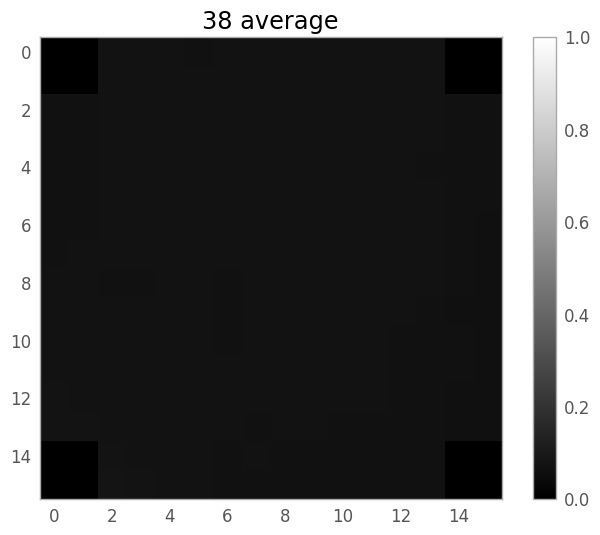

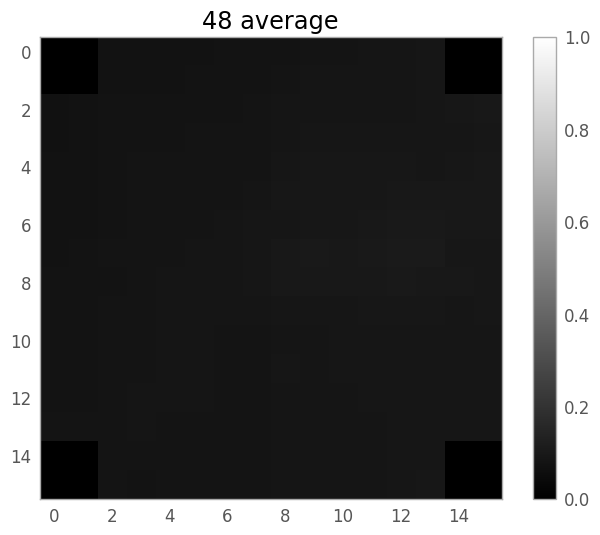

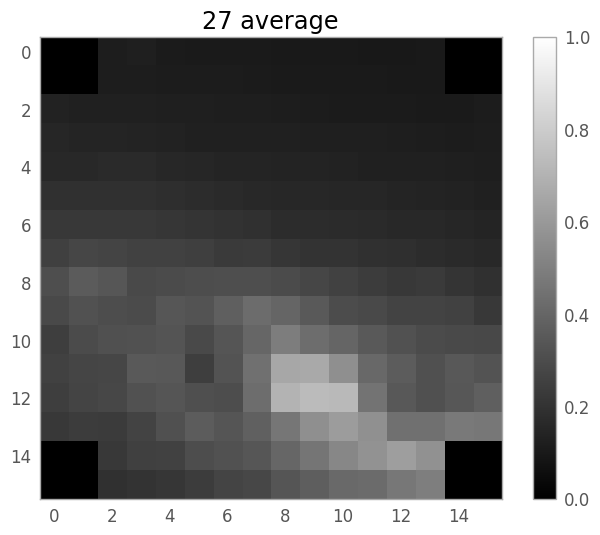

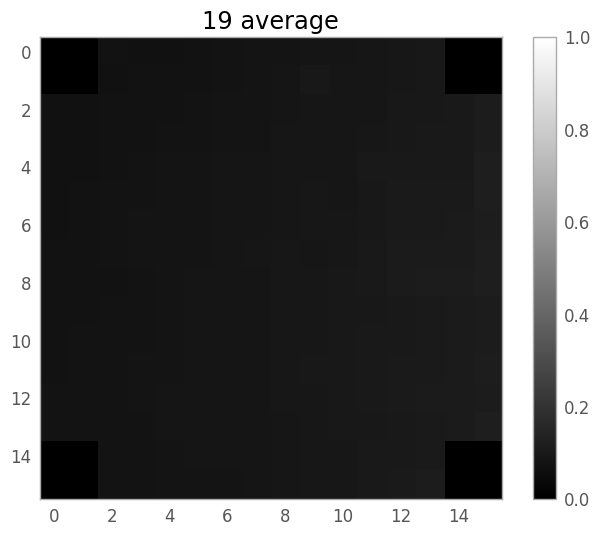

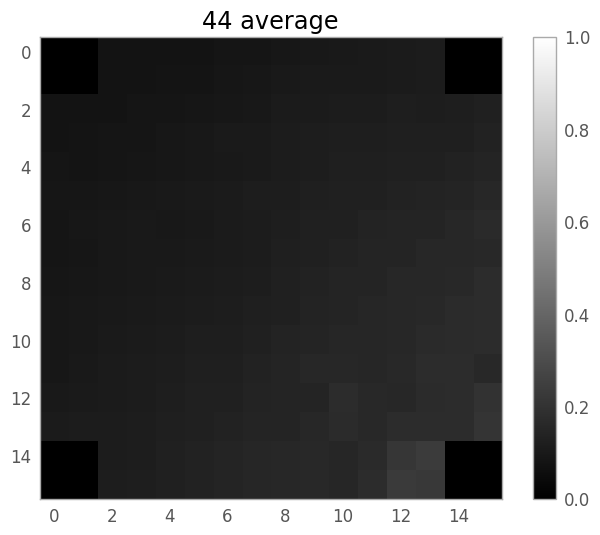

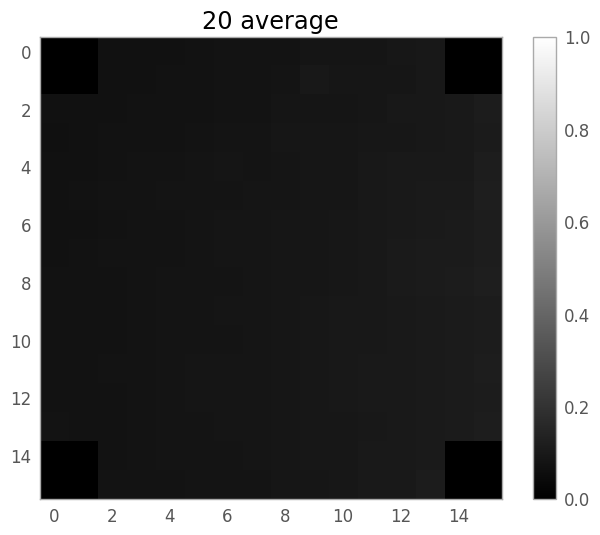

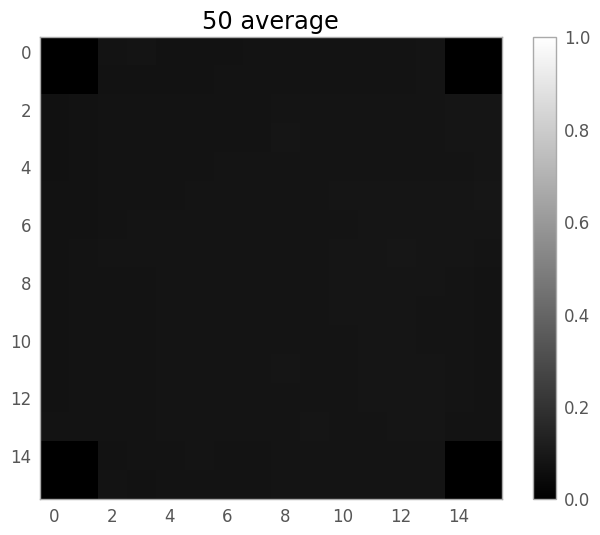

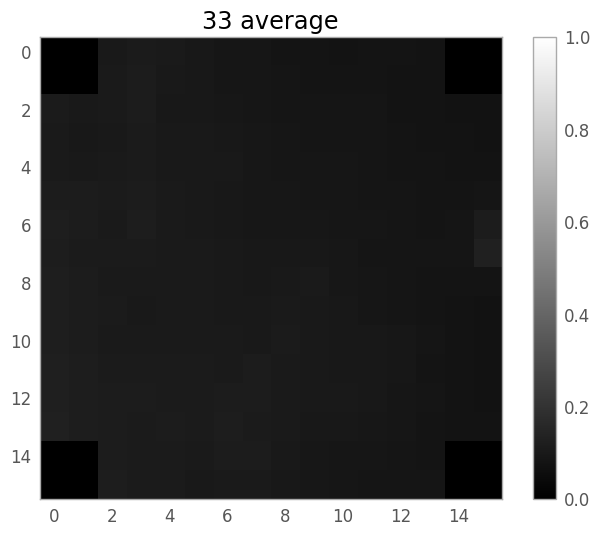

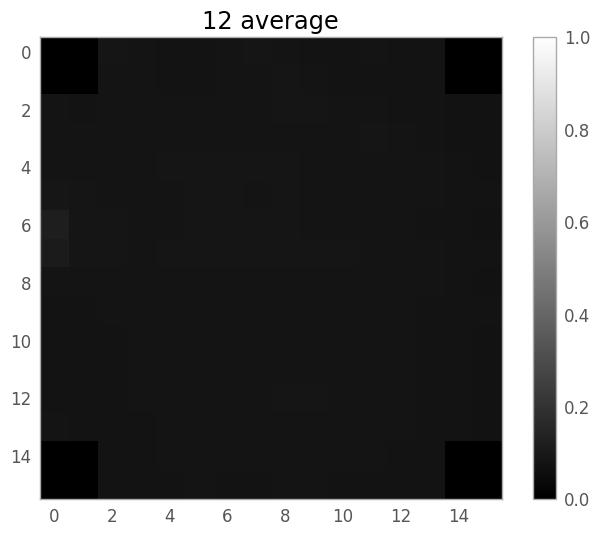

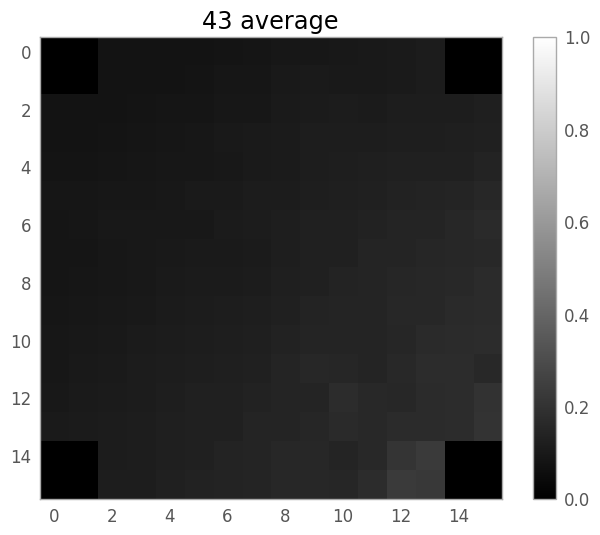

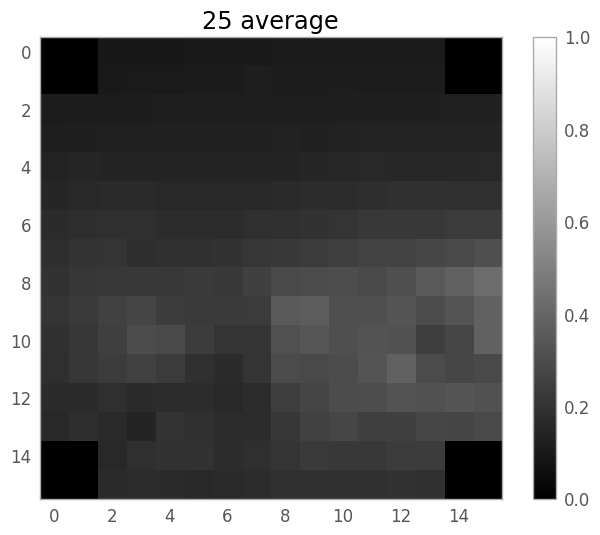

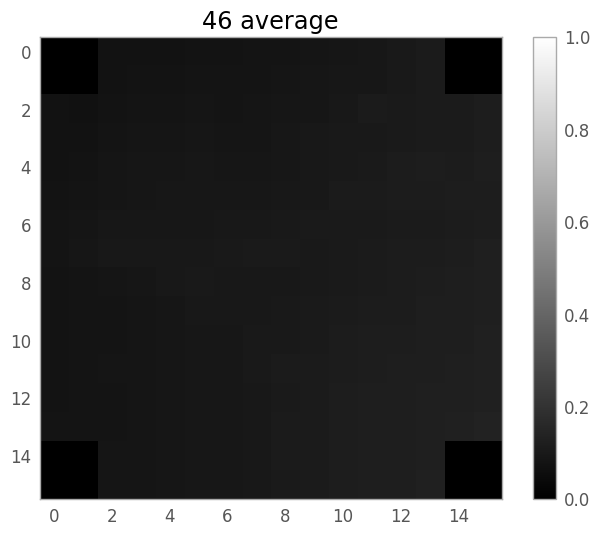

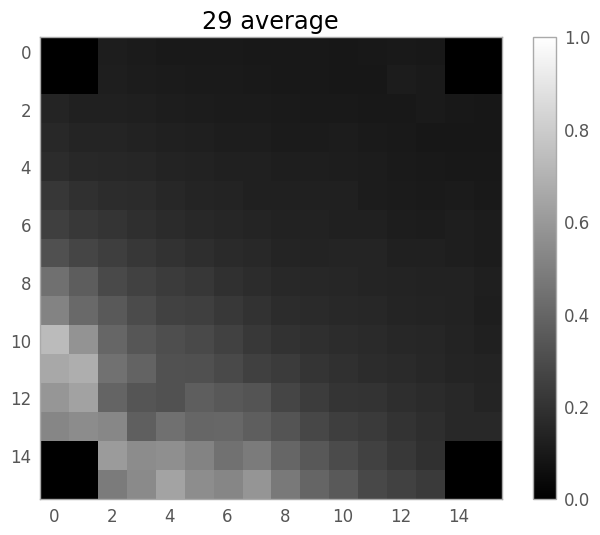

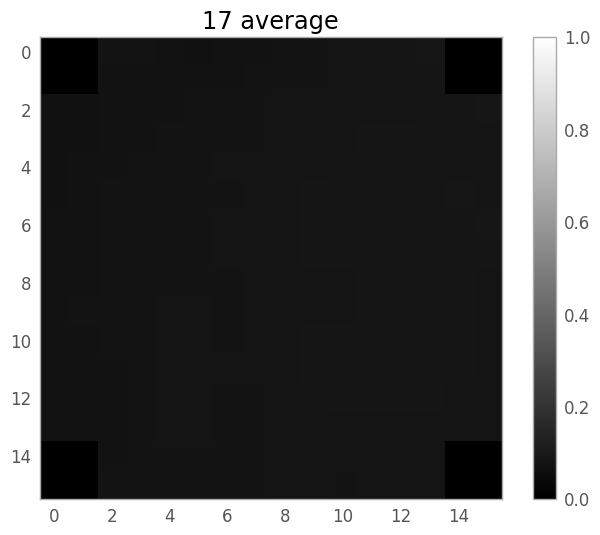

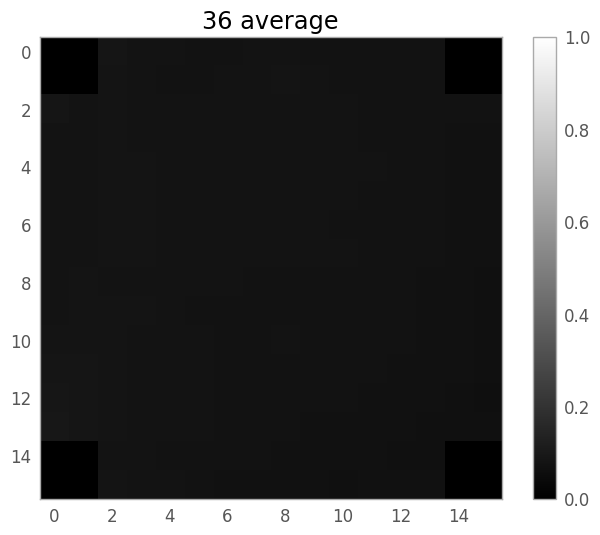

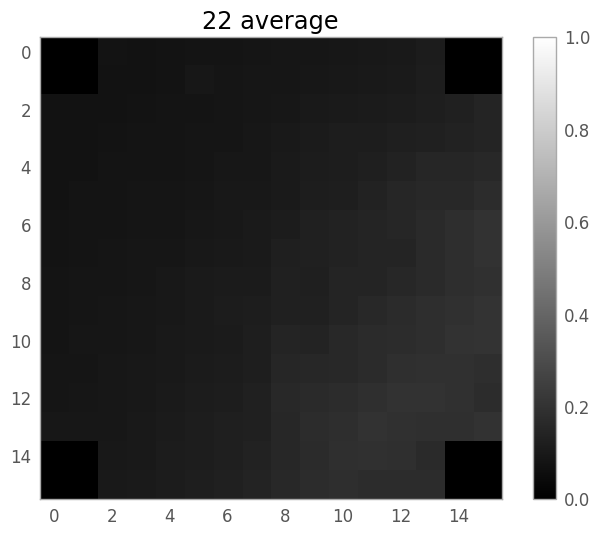

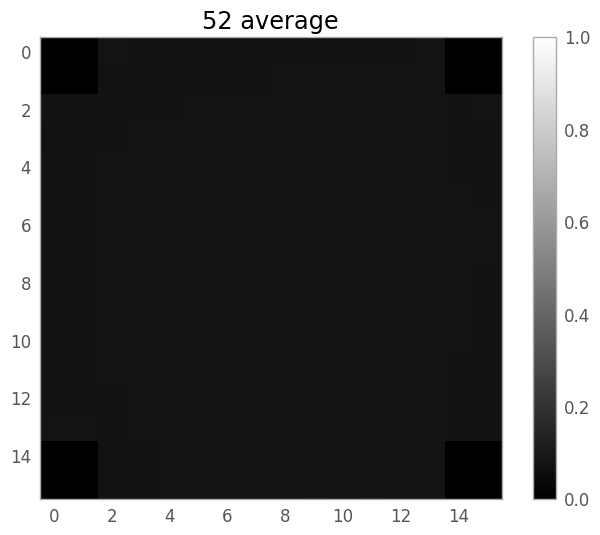

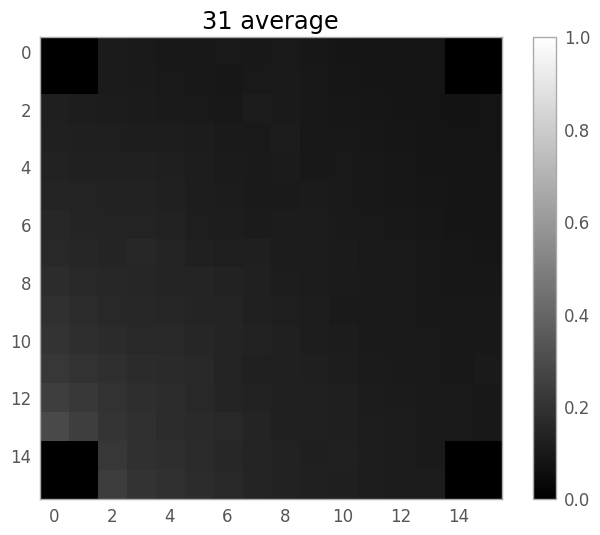

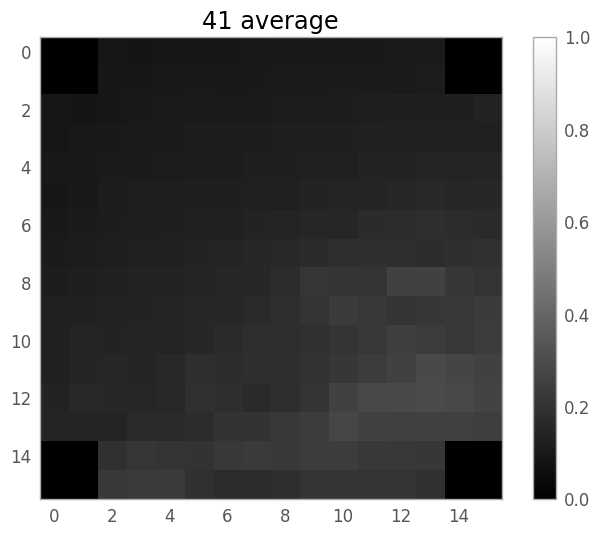

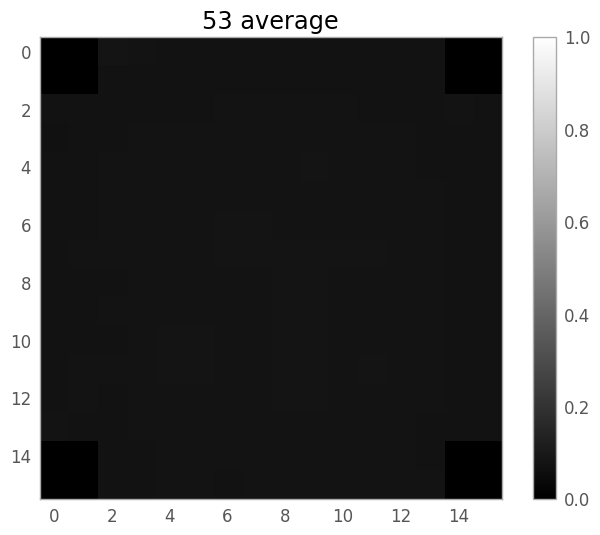

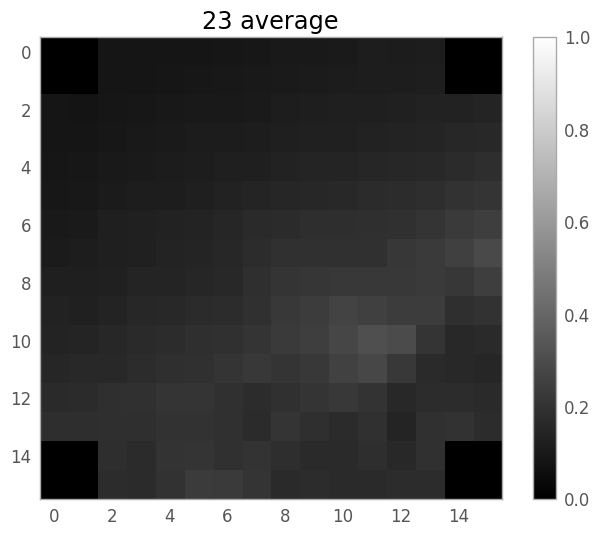

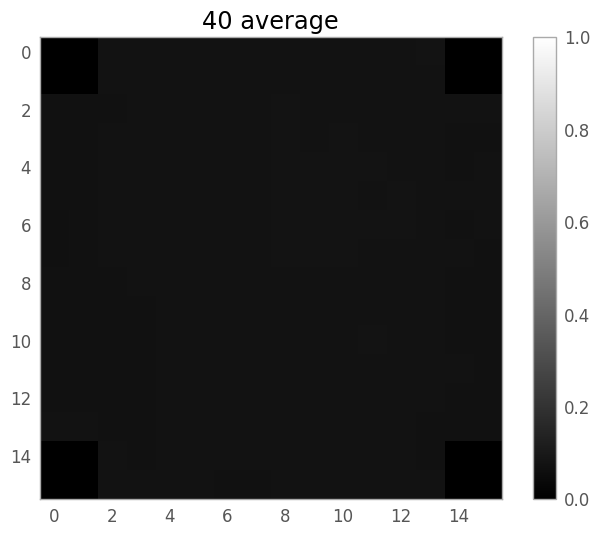

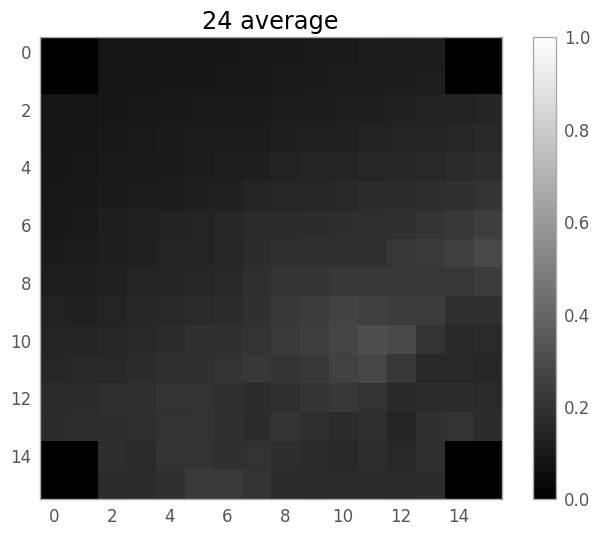

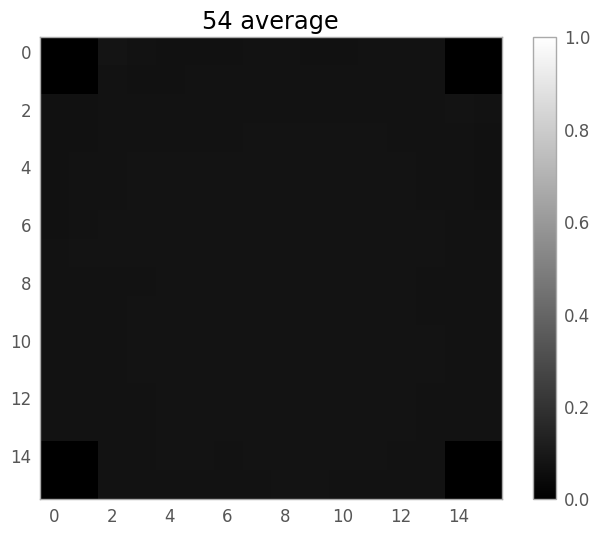

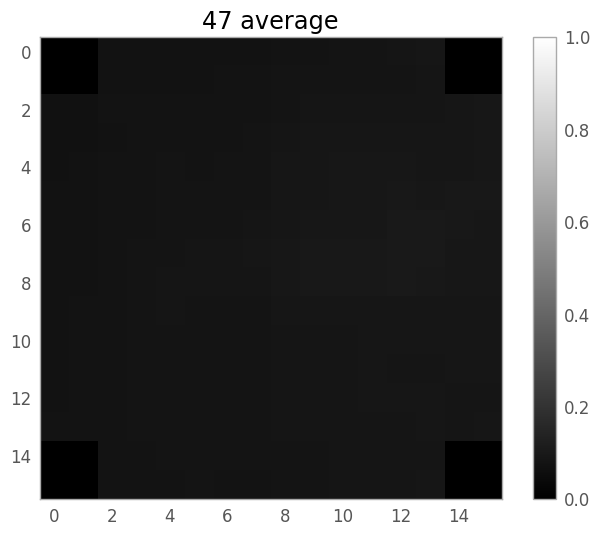

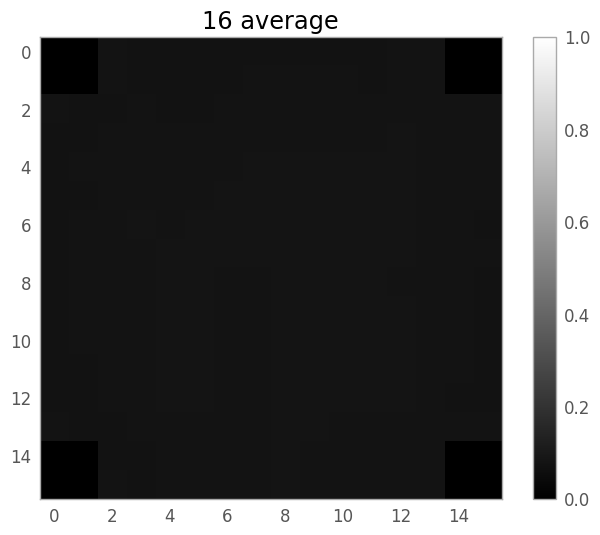

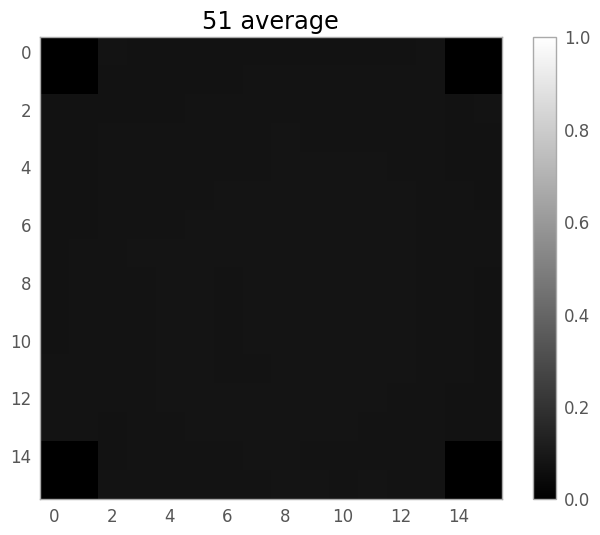

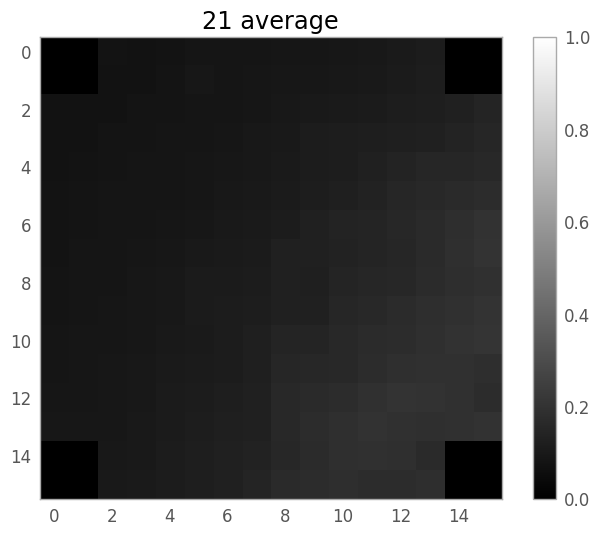

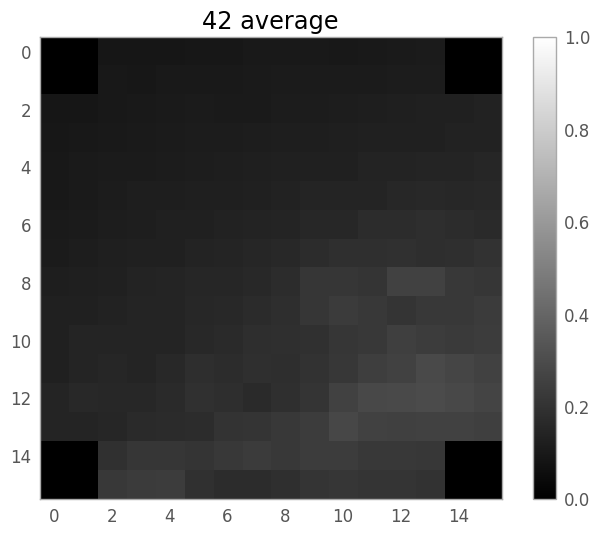

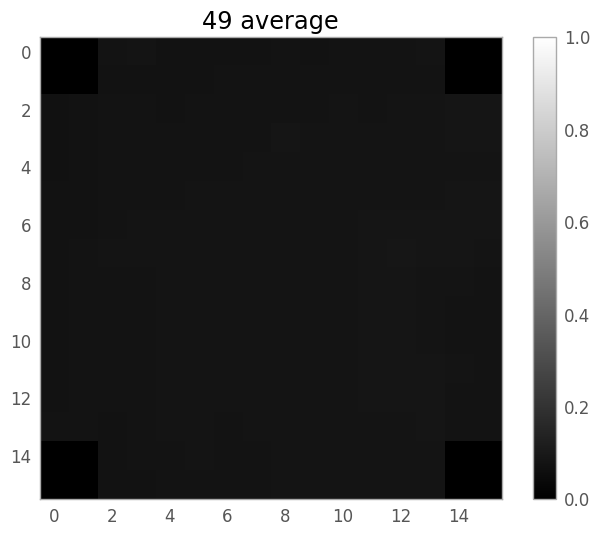

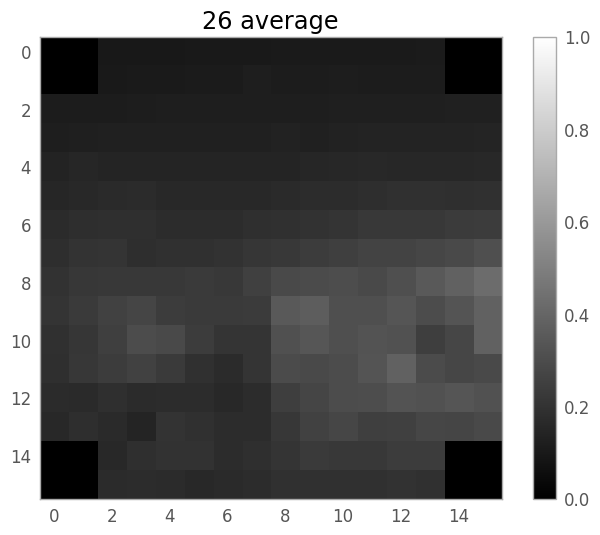

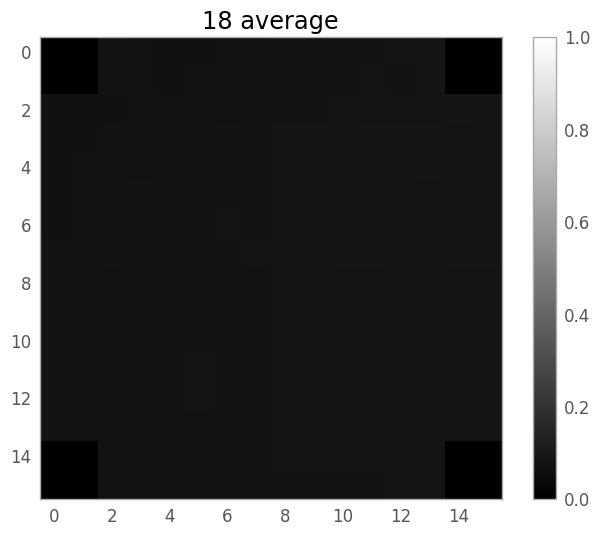

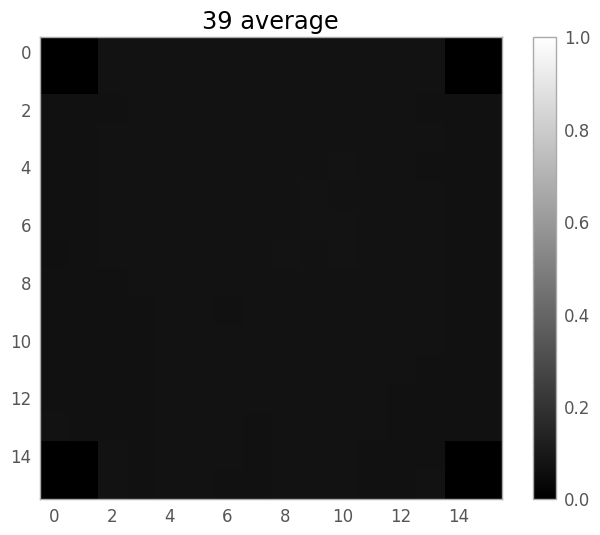

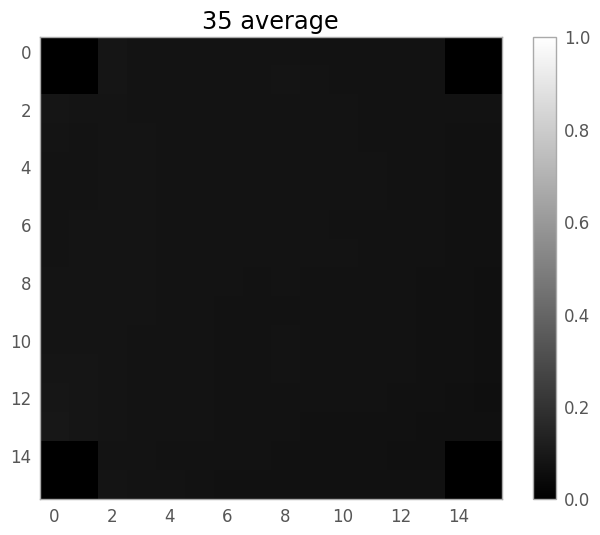

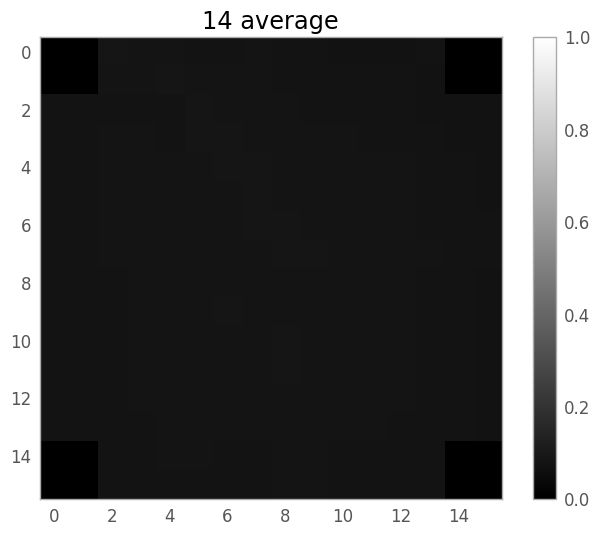

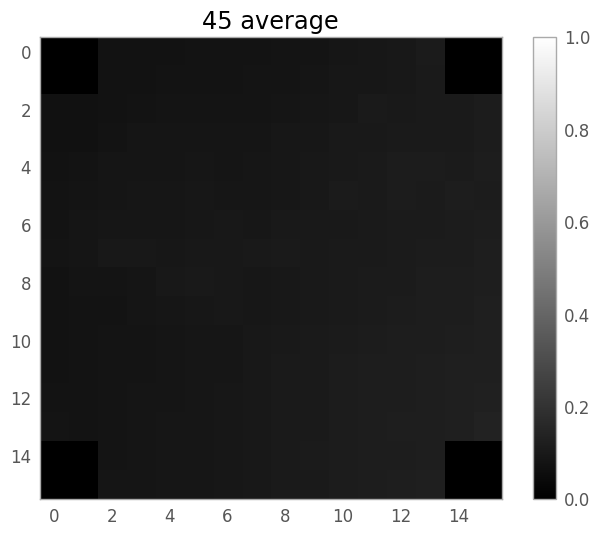

In [56]:
# displaying saved background images
for filename in os.listdir(background_ccd_folder):
    if filename[0] != 'O': continue
    image_avg = pickle.load(open(background_ccd_folder+filename, "rb"))
    orbit = filename[1:3]


    # displaying images
    fig,ax = plt.subplots()
    im = ax.imshow(image_avg, cmap="gray", vmin=0, vmax=1) # for when all pixels are between 0 and 1
    plt.grid(visible=False)
    colorbar = fig.colorbar(im)
    ax.set_title(orbit + ' average')
    plt.show()
    plt.close()

In [57]:
# # Compares before-and-after images for subtraction code
# orbit_to_show = 13
# ffis_to_show = orbit_to_images_below_sunshade[orbit_to_show]

# for ffi in ffi_to_show:




